# Tutorial \#3: Blach Hole and Accretion Disk Parameters

**Nicolás Guerra-Varas**
Professor Dragana Ilić
Tutor Isidora Jankov

Date: 

Data: sample of 500 SDSS quasars (QSOs) with spectral parameters from __[Shen et al. 2011
](https://ui.adsabs.harvard.edu/abs/2011ApJS..194...45S/abstract)__ (__[VizieR catalog](https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/ApJS/194/45)__).

The goal of this tutorial is to learn how to estimate the mass of the black hole (BH) of active galactic nuclei (AGN) with indirect methods: scaling relationships from reverberation mapping (RM) and the use of the bulge luminosity of the host galaxy.

---

## Imports

In [165]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('bmh')

import seaborn as sns
sns.set_theme()
sns.set_context('paper')

from collections import Counter

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Preparing the data

In [2]:
qsos = pd.read_csv('shen_subsample_500.csv')
qsos.reset_index(inplace=True, drop=True)
qsos

,RAJ2000,DEJ2000,Plate,Fiber,MJD,iMAG,logLbol,e_logLbol,logLBHb,e_logLBHb,W_BHb_,e_W_BHb_,EWBHb,e_EWBHb,SN_Hb_,logBH,e_logBH,logEdd
0,189.67804,45.30687,1372,486,53062,-23.20,45.236,0.004,42.35,0.02,4399.3,330.1,62.0,3.1,23.06,8.33,0.07,-1.20
1,189.77188,41.44564,1984,609,53433,-22.29,44.819,0.005,42.11,0.04,2371.4,541.6,89.4,8.7,15.06,7.59,0.20,-0.87
2,189.81419,53.23740,885,449,52379,-22.69,45.121,0.004,41.93,0.04,10756.6,4366.4,32.1,3.4,16.27,9.05,0.35,-2.03
3,189.93733,19.90707,2614,350,54481,-23.37,45.132,0.001,42.55,0.02,15241.3,362.8,118.7,6.3,19.79,9.36,0.02,-2.33
4,189.99405,49.09448,1278,96,52735,-22.77,45.166,0.011,42.25,0.01,1385.6,48.6,52.5,2.9,15.96,7.29,0.03,-0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,231.08040,27.95578,1846,28,54173,-23.33,45.423,0.005,42.56,0.02,9345.2,348.3,60.6,3.4,24.76,9.08,0.03,-1.76
496,231.09229,26.70657,2160,444,53885,-22.72,44.989,0.005,42.19,0.04,4363.7,503.4,73.2,6.8,17.34,8.20,0.10,-1.31
497,231.11946,30.54376,1650,545,53174,-24.56,45.891,0.001,43.14,0.01,2572.5,106.9,76.1,1.9,40.15,8.19,0.04,-0.40
498,231.12225,35.25613,1354,466,52814,-22.60,45.143,0.005,41.80,0.05,1559.7,243.2,21.0,2.7,15.44,7.38,0.14,-0.34


In [3]:
qsos.shape

(500, 18)

In [4]:
qsos.columns

Index(['RAJ2000', 'DEJ2000', 'Plate', 'Fiber', 'MJD', 'iMAG', 'logLbol',
       'e_logLbol', 'logLBHb', 'e_logLBHb', 'W_BHb_', 'e_W_BHb_', 'EWBHb',
       'e_EWBHb', 'SN_Hb_', 'logBH', 'e_logBH', 'logEdd'],
      dtype='object')

The columns have the following information:
* `RAJ2000`, `DEJ2000`: right ascension and declination in degrees
* Plate, MJD and FiberID
* `iMAG`: absolute i-band magnitude
* `logLbol`, `e_logLbol`: bolometric luminosity and its error [erg s $^{-1}$ ]
* `logLBHb`, `e_logLBHb`: broad H $\beta$ line luminosity [erg s $^{-1}$ ]
* `W_BHb_`, `e_W_BHb_`: FWHM of broad H$\beta$ and its error [km s $^{-1}$ ]
* `EWBHb`, `e_EWBHb`: Restframe equivalent width of broad H $\beta$ and its error [0.1 nm]
* `SN_Hb_`: median signal-to-noise per pixel for the restframe 4750-4950 Ang region
* `logBH`, `e_logBH`: adopted fiducial virial BH mass and its error [M_{\odot}]
* `logEdd`: Eddington ratio based on the fiducial virial BH mass

In [5]:
# the names of the columns are difficult to understand
qsos.rename(columns={'logLbol': 'log_Lbol',  # bolometric lum
                     'e_logLbol': 'log_Lbol_error',  # bolometric lum error
                     'logLBHb': 'log_broad_L_h_beta',  # H_beta broad lum
                     'e_logLBHb': 'log_broad_L_h_beta_error',  # H_beta broad lum error
                     'W_BHb_': 'fwhm_h_beta', 
                     'e_W_BHb_': 'fwhm_h_beta_error', 
                     'EWBHb': 'eq_wid_h_beta', 
                     'e_EWBHb': 'eq_wid_h_beta_error', 
                     'SN_Hb_': 'sig_noise_h_beta', 
                     'logBH': 'log_BH_mass',
                     'e_logBH': 'log_BH_mass_error'
                     }, inplace=True)

## Scaling relations from RM

First, I got a `.txt` file with plate, mjd and fiber ID for SDSS cross-match

In [6]:
cross_id = qsos[['Plate', 'MJD', 'Fiber']]
cross_id

,Plate,MJD,Fiber
0,1372,53062,486
1,1984,53433,609
2,885,52379,449
3,2614,54481,350
4,1278,52735,96
...,...,...,...
495,1846,54173,28
496,2160,53885,444
497,1650,53174,545
498,1354,52814,466


In [7]:
qsos.shape

(500, 18)

In [8]:
cross_id.shape

(500, 3)

In [9]:
Counter(cross_id.duplicated())

Counter({False: 500})

In [10]:
# cross_id_str = cross_id.to_string(index=False, header=False)
# cross_id_file = open('cross_id_input.txt', 'a')
# cross_id_file.write(cross_id_str)
# cross_id_file.close()

I used the `cross_id_input.txt` file to cross match the sample with SDSS in the __[CrossMatch Tool](https://skyserver.sdss.org/dr18/CrossMatchTools/ObjectCrossID)__. The SQL query I used is:

```
SELECT s.z AS redshift, g.h_beta_flux, s.ra, s.dec, s.plate, s.mjd, s.fiberID
FROM #upload u
      JOIN SpecObjAll as s
      ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
      JOIN
      GalSpecLine AS g
      ON g.specobjid = s.specobjid
```

The result is in the `crosmatch_shen_subsample.csv` file.

In [11]:
sdss_qsos = pd.read_csv('crosmatch_shen_subsample.csv', skiprows=1)
sdss_qsos

,redshift,h_beta_flux,ra,dec,plate,mjd,fiberID
0,0.183985,300.96690,195.03333,3.932381,849,52439,300
1,0.252761,391.48320,217.41974,3.357194,585,52027,214
2,0.268422,410.67200,219.91783,3.091284,586,52023,89
3,0.192150,199.62830,201.07607,58.819914,959,52411,192
4,0.171041,153.48380,203.15810,59.514940,960,52425,321
...,...,...,...,...,...,...,...
495,0.250829,15.71955,200.50446,51.710448,1667,53430,543
496,0.258147,525.93010,221.39478,46.643204,1675,53466,428
497,0.227546,210.10160,205.87458,28.055933,2017,53474,180
498,0.211458,172.48770,205.95884,28.034967,2017,53474,168


In [12]:
sdss_qsos.columns

Index(['redshift', 'h_beta_flux', 'ra', 'dec', 'plate', 'mjd', 'fiberID'], dtype='object')

In [13]:
sdss_qsos.shape

(500, 7)

In [14]:
qsos.shape

(500, 18)

In [15]:
# I joined the dfs so it's easier to manipulate
sdss_qsos.rename(columns={'plate': 'Plate', 'mjd': 'MJD', 'fiberID': 'Fiber'}, inplace=True)
qsos = qsos.merge(sdss_qsos, on=['Plate', 'MJD', 'Fiber'])

In [16]:
qsos.shape

(500, 22)

In [17]:
# merge done correctly!
# new # of cols is equal to old qsos # of cols 
# + sdss_qsos # of cols - 3 cols (which are plate, mjd, fiber)
qsos.shape[1] == 18 + 7 - 3

True

There were no lost objects. In this step, I realised that the text file used for the SDSS SQL query needs a header, as it never processes the first line of text.

### Exploratory Plots

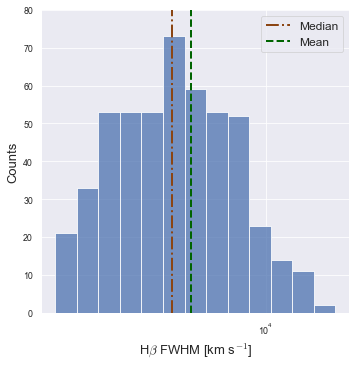

In [18]:
sns.displot(data=qsos, x='fwhm_h_beta', palette='colorblind', log_scale=True)
plt.vlines(qsos['fwhm_h_beta'].median(), 0, 80, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['fwhm_h_beta'].mean(), 0, 80, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 80)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'H$\beta$ FWHM [km s$^{-1}$]', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('Plots/qsos_Hbeta_fwhm_distr.pdf')

plt.show()

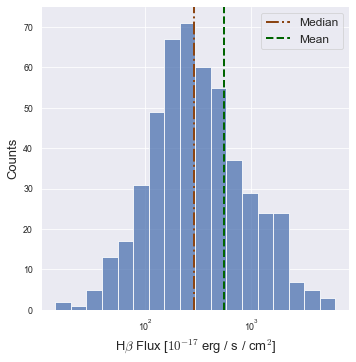

In [19]:
sns.displot(data=qsos, x='h_beta_flux', palette='colorblind', log_scale=True)
plt.vlines(qsos['h_beta_flux'].median(), 0, 75, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['h_beta_flux'].mean(), 0, 75, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 75)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'H$\beta$ Flux [$10^{-17}$ erg / s / cm$^2$]', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('Plots/qsos_Hbeta_flux_distr.pdf')

plt.show()

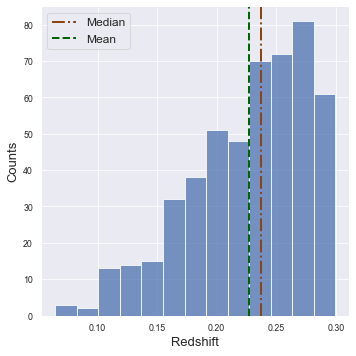

In [20]:
sns.displot(data=qsos, x='redshift', palette='colorblind')
plt.vlines(qsos['redshift'].median(), 0, 85, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['redshift'].mean(), 0, 85, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 85)

plt.ylabel('Counts', fontsize=13);
plt.xlabel('Redshift', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('Plots/qsos_z_distr.pdf')

plt.show()

In [21]:
# magnitudes are negative, so I plot them with their absolute value
qsos['iMAG_abs'] = np.abs(qsos['iMAG'])

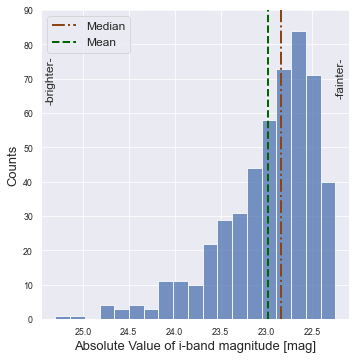

In [22]:
sns.displot(data=qsos, x='iMAG_abs', palette='colorblind')
plt.vlines(qsos['iMAG_abs'].median(), 0, 90, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['iMAG_abs'].mean(), 0, 90, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 90)

ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])

plt.text(25.4, 63, '-brighter-', fontsize=12, rotation=90);
plt.text(22.25, 65, '-fainter-', fontsize=12, rotation=90);

plt.ylabel('Counts', fontsize=13);
plt.xlabel('Absolute Value of i-band magnitude [mag]', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('Plots/qsos_iMAG_distr.pdf')

plt.show()

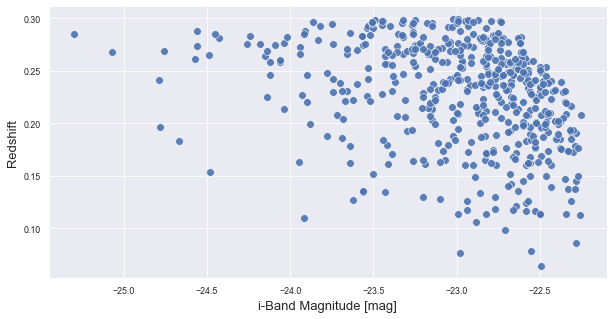

In [23]:
f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='iMAG', y='redshift', palette='colorblind', s=60, alpha=0.9)

plt.xlabel(r'i-Band Magnitude [mag]', fontsize=13);
plt.ylabel('Redshift', fontsize=13);

# plt.savefig('Plots/qsos_imag_vs_z.pdf')

plt.show()

In [24]:
qsos[['iMAG', 'redshift', 'fwhm_h_beta']].describe()

,iMAG,redshift,fwhm_h_beta
count,500.00000,500.000000,500.000000
mean,-22.98284,0.226942,4825.009600
std,0.52241,0.049635,2975.763737
min,-25.30000,0.064495,1281.100000
25%,-23.25000,0.193991,2621.675000
50%,-22.84000,0.236845,3997.300000
75%,-22.60000,0.267921,6338.725000
max,-22.25000,0.299768,19717.100000


### Limitations of the Sample

The sample doesn't have even distributions in magnitude or in redshift. The majority of the objects are distant, and their redshift is above the median of 0.237. Similarly, the majority of the objects' i-band magnitude is fainter than their median (-22.84 mag). In other words, the sample has a selection of fainter and more distant QSOs. This might bias the results later on.

#### FWHM

To calculate the Full Width Half Maximum (FWHM) of other lines, I went back to the SDSS Cross-Match tool to download the velocity dispersions $\sigma$ of the lines. The FWHM can be calculated with:
\begin{align}
      \text{FWHM} = 2 \sqrt{ 2 \ln{2} } \times \sigma \approx 2.355 \times \sigma
\end{align}

This is the SQL query I used:

```
SELECT s.plate, s.mjd, s.fiberID, g.sigma_balmer, g.sigma_forbidden
FROM #upload u
      JOIN SpecObjAll s
      ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
      JOIN GalSpecLine AS g
      ON g.specobjid = s.specobjid
```

In addition to the Balmer series lines, I also downloaded the velocity dispersion for the forbidden lines just in case it comes in handy. The result of this query is in `vel_dispersions.csv`.

---

The most efficient SQL query that downloads all needed information would have been:
```
SELECT s.z AS redshift, g.h_beta_flux, g.sigma_balmer, g.sigma_forbidden
FROM #upload u
      JOIN SpecObjAll as s
      ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
      JOIN
      GalSpecLine AS g
      ON g.specobjid = s.specobjid
```

In [25]:
def FWHM(sigma):
    '''
    Full Width Halfh Maximum in [km/s]
    from vel dispersion in [km/s]
    '''
    return 2.355 * sigma

In [26]:
sigmas = pd.read_csv('vel_dispersions.csv', header=1)
sigmas.drop_duplicates(inplace=True)  # there are two identical rows per object
sigmas

,plate,mjd,fiberID,sigma_balmer,sigma_forbidden
0,1045,52725,72,313.062,291.7598
1,1050,52721,500,500.000,245.1475
2,1344,52792,91,500.000,282.8331
3,1346,52822,86,500.000,500.0000
4,1378,53061,574,500.000,206.1464
...,...,...,...,...,...
982,2115,53535,265,500.000,500.0000
983,2160,53885,243,500.000,500.0000
984,2770,54510,433,500.000,500.0000
985,2771,54527,71,500.000,253.8604


In [27]:
# merging with main df again
sigmas.rename(columns={'plate': 'Plate', 'mjd': 'MJD', 'fiberID': 'Fiber'}, inplace=True)
qsos = qsos.merge(sigmas, on=['Plate', 'MJD', 'Fiber'])

In [28]:
qsos.shape[1] == 22 + 2

False

In [29]:
qsos.columns

Index(['RAJ2000', 'DEJ2000', 'Plate', 'Fiber', 'MJD', 'iMAG', 'log_Lbol',
       'log_Lbol_error', 'log_broad_L_h_beta', 'log_broad_L_h_beta_error',
       'fwhm_h_beta', 'fwhm_h_beta_error', 'eq_wid_h_beta',
       'eq_wid_h_beta_error', 'sig_noise_h_beta', 'log_BH_mass',
       'log_BH_mass_error', 'logEdd', 'redshift', 'h_beta_flux', 'ra', 'dec',
       'iMAG_abs', 'sigma_balmer', 'sigma_forbidden'],
      dtype='object')

In [30]:
qsos['fwhm_balmer'] = qsos.apply(lambda x: FWHM(x['sigma_balmer']), axis=1)
qsos['fwhm_forbidden'] = qsos.apply(lambda x: FWHM(x['sigma_forbidden']), axis=1)
qsos

,RAJ2000,DEJ2000,Plate,Fiber,MJD,iMAG,log_Lbol,log_Lbol_error,log_broad_L_h_beta,log_broad_L_h_beta_error,...,logEdd,redshift,h_beta_flux,ra,dec,iMAG_abs,sigma_balmer,sigma_forbidden,fwhm_balmer,fwhm_forbidden
0,189.67804,45.30687,1372,486,53062,-23.20,45.236,0.004,42.35,0.02,...,-1.20,0.228846,323.90260,189.67803,45.306863,23.20,500.0000,433.6110,1177.500000,1021.153905
1,189.77188,41.44564,1984,609,53433,-22.29,44.819,0.005,42.11,0.04,...,-0.87,0.178252,448.13070,189.77188,41.445637,22.29,500.0000,291.3802,1177.500000,686.200371
2,189.81419,53.23740,885,449,52379,-22.69,45.121,0.004,41.93,0.04,...,-2.03,0.201624,86.80108,189.81417,53.237400,22.69,288.9515,397.9982,680.480783,937.285761
3,189.93733,19.90707,2614,350,54481,-23.37,45.132,0.001,42.55,0.02,...,-2.33,0.239360,370.09130,189.93734,19.907090,23.37,226.5555,209.3104,533.538203,492.925992
4,189.99405,49.09448,1278,96,52735,-22.77,45.166,0.011,42.25,0.01,...,-0.23,0.235311,589.24180,189.99405,49.094498,22.77,414.4889,117.9253,976.121360,277.714081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,231.08040,27.95578,1846,28,54173,-23.33,45.423,0.005,42.56,0.02,...,-1.76,0.284370,118.15860,231.08041,27.955782,23.33,500.0000,152.5751,1177.500000,359.314360
496,231.09229,26.70657,2160,444,53885,-22.72,44.989,0.005,42.19,0.04,...,-1.31,0.236137,324.73740,231.09229,26.706561,22.72,500.0000,338.4847,1177.500000,797.131468
497,231.11946,30.54376,1650,545,53174,-24.56,45.891,0.001,43.14,0.01,...,-0.40,0.273973,2162.26000,231.11947,30.543761,24.56,500.0000,383.8575,1177.500000,903.984413
498,231.12225,35.25613,1354,466,52814,-22.60,45.143,0.005,41.80,0.05,...,-0.34,0.249451,252.49410,231.12225,35.256130,22.60,434.0521,212.5933,1022.192696,500.657221


In [31]:
qsos.columns

Index(['RAJ2000', 'DEJ2000', 'Plate', 'Fiber', 'MJD', 'iMAG', 'log_Lbol',
       'log_Lbol_error', 'log_broad_L_h_beta', 'log_broad_L_h_beta_error',
       'fwhm_h_beta', 'fwhm_h_beta_error', 'eq_wid_h_beta',
       'eq_wid_h_beta_error', 'sig_noise_h_beta', 'log_BH_mass',
       'log_BH_mass_error', 'logEdd', 'redshift', 'h_beta_flux', 'ra', 'dec',
       'iMAG_abs', 'sigma_balmer', 'sigma_forbidden', 'fwhm_balmer',
       'fwhm_forbidden'],
      dtype='object')

### H $\beta$ Luminosity

Next up, I'll try and find the luminosity of the H $\beta$ line.

First, I'll calculate the luminosity distance $D_L$ using a simple cosmological model from __[`astropy`](https://docs.astropy.org/en/stable/index.html)__.

In [32]:
# cosmological constants
H0 = 67.8  # km / s Mpc
Omega_m = 0.31  # Matter density parameter
Omega_l = 0.69  # Dark energy density parameter

In [33]:
# astropy.cosmology for the luminosity distance
cosmo = FlatLambdaCDM(H0=H0 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=Omega_m)

In [34]:
D_Ls = cosmo.luminosity_distance(qsos['redshift'])
D_Ls  # in Mpc

<Quantity [1175.10239108,  889.10182071, 1019.51837712, 1236.22526889,
           1212.61632755, 1214.37128809,  964.48930188,  790.76709941,
           1201.82735012,  815.09985814,  967.45018781, 1240.87670497,
           1294.77297817, 1375.84377434, 1242.72976706, 1486.92066416,
           1161.82242278, 1382.67951026,  973.44538514, 1439.3851282 ,
           1084.4651613 , 1049.60520548, 1392.41424251, 1419.54254503,
            800.85638954,  806.05363879,  735.44851732, 1200.25232751,
            909.84229149, 1488.09458768,  945.34555698, 1440.55280425,
           1018.4349768 , 1396.45598442, 1236.80469588, 1312.09319998,
            611.98944253, 1048.71596038, 1338.89647652,  986.00652138,
           1572.13812807, 1432.13488533, 1347.79437041, 1064.80378005,
           1218.13540371, 1239.53370197,  792.42571306, 1443.70200013,
           1391.93695966,  920.81597032,  696.73778185, 1329.13824936,
           1192.63645161, 1295.09878323, 1445.05326959, 1509.32433588,
      

In [35]:
qsos['lum_dist'] = np.asarray(D_Ls)

Next, I'll calculate the luminosity of the H$\beta$ line. From the formula found in __[Hogg 2000](https://arxiv.org/abs/astro-ph/9905116)__:
\begin{align}
    \nu S_{\nu} = \frac{\nu_e L_{\nu_e}}{4 \pi {D_L}^2}
\end{align}

This is formula number 24 in the paper. $S_{\nu}$ is the differential flux at frequency $\nu$, $\nu_e = (1 + z) \nu$ is the emitted frequency, and $L_{\nu_e}$ is thedifferential luminosity at frequency $\nu$.

I can obtain the luminosity $L_{\nu_e}$:
\begin{align}
    L_{\nu_e} = 4 \pi {D_L}^2 S_{\nu} \frac{1}{(1 + z)}
\end{align}

In [36]:
def L_from_D_L(D_L, flux, redshift):
    '''
    Formula #24 from Hogg 2000
    Solved for luminosity

    Inputs:
    D_L: luminosity distance in Mpc
    flux: in 1e-17 erg / (s cm^2)
    redshift: dimensionless

    Output:
    Luminosity in erg / s
    '''

    # 1 pc = 3.0857e16 meters = 3.0857e18 centimeters
    D_L_cm = D_L * 1e6 *3.0857e18

    return 4 * np.pi * D_L_cm**2 * (flux * 1e-17) / (1 + redshift)

In [37]:
# prefix my_ is so that I can distinguish between given and calculated values
qsos['my_L_h_beta'] = qsos.apply(lambda x: L_from_D_L(x['lum_dist'], x['h_beta_flux'], x['redshift']), axis=1)
qsos['my_log_L_h_beta'] = np.log10(qsos['my_L_h_beta'])
qsos[['my_L_h_beta', 'my_log_L_h_beta']].describe()

,my_L_h_beta,my_log_L_h_beta
count,5.000000e+02,500.000000
mean,6.002269e+41,41.589856
std,7.029190e+41,0.402436
min,2.246757e+40,40.351556
25%,2.125899e+41,41.327540
50%,3.926674e+41,41.594014
75%,7.311513e+41,41.864006
max,6.700309e+42,42.826095


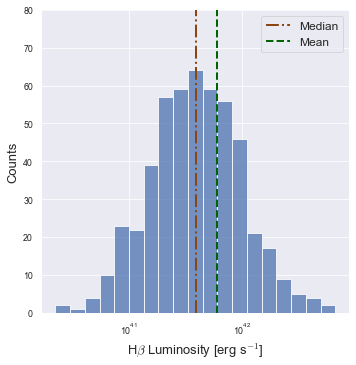

In [38]:
sns.displot(data=qsos, x='my_L_h_beta', palette='colorblind', log_scale=True)
plt.vlines(qsos['my_L_h_beta'].median(), 0, 80, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['my_L_h_beta'].mean(), 0, 80, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 80)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'H$\beta$ Luminosity [erg s$^{-1}$]', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('Plots/Hbeta_lum_distr.pdf')

plt.show()

I can quickly compare my obtained value for the luminosity of the H $\beta$ line with the one provided in the sample:

In [39]:
qsos[['log_broad_L_h_beta', 'my_log_L_h_beta']].describe()

,log_broad_L_h_beta,my_log_L_h_beta
count,500.000000,500.000000
mean,42.316980,41.589856
std,0.338659,0.402436
min,40.680000,40.351556
25%,42.120000,41.327540
50%,42.300000,41.594014
75%,42.500000,41.864006
max,43.420000,42.826095


/Users/nicolasgalvarinoguerravaras/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


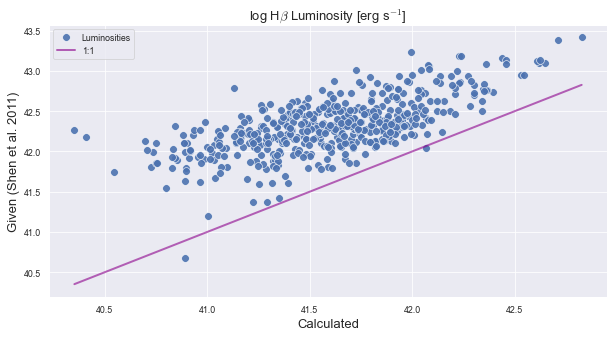

In [40]:
f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='my_log_L_h_beta', y='log_broad_L_h_beta', palette='colorblind', 
                s=60, alpha=0.9, label='Luminosities')

x_to_plot = np.linspace(qsos['my_log_L_h_beta'].min(), qsos['my_log_L_h_beta'].max(), 50)
sns.lineplot(x_to_plot, x_to_plot, linewidth=2, color='darkmagenta', label='1:1', alpha=0.6)

plt.xlabel(r'Calculated', fontsize=13);
plt.ylabel('Given (Shen et al. 2011)', fontsize=13);
plt.title(r'log H$\beta$ Luminosity [erg s$^{-1}$]', fontsize=13);

# plt.savefig('Plots/calculated_vs_given_Hbeta_lum.pdf')

plt.show()

I note that my calculated values are systematically lower than the given ones. This might be because of the luminosity distance. It might be an underestimation of the true distance to the object, which results in a lower luminosity.

### BH Mass with Empirical Relation

__[Wu 2009](http://adsabs.harvard.edu/abs/2009MNRAS.398.1905W)__, presents relations to calculate black hole (BH) masses, Eddington ratios and possible relations between [OIII] kinematics and the accretion and jet properties. These are valid for a specific type of AGN: GHz-peaked-spectrum (GPS) and compact steep-spectrum (CSS) radio sources, which are compact radio galaxies. Their spectra have a peak at ~1 GHz and ~1000 GHz respectively.

The sample presented in the paper is not a complete sample of radio galaxies. Instead, the author focused on making it characteristic of these kind of objects. The redshift distribution of this sample differs from the one used in this tutorial, as it goes from ~0.1 to ~3.5, whilst the sample analysed here has redshift below 0.30. In addition, radio galaxies may not necessarily be QSOs, so the type of AGN in both samples is not quite the same.

In Section 3.1, estimations for the BH mass are presented. Assuming that the gas around the BH is virialised, i.e. gravitationally bound to the BH, the BH mass can be estimated as:
\begin{align}
    M_{BH} = \frac{R_{BLR} V^2}{G},
\end{align}

where $R_{BLR}$ is the size of the broad line region (BLR), which is assumed to be isotropic, $V$ is estimated from the FWHM of a broad emission line and $G$ is the gravitational constant. 


\begin{align}
    M_{BH} = 2.4 \times 10^6 \left ( \frac{L_{ \text{H} \beta }}{10^{42} \text{ erg s}^{-1} } \right )^{0.59} \left ( \frac{ \text{FWHM}_{ \text{H} \beta } }{ 10^3 \text{ km s}^{-1} } \right )^2 M_{\odot}
\end{align}

In [41]:
def M_BH_Wu(L_h_beta, fwhm_h_beta):
    '''
    Formula #2 from Wu 2009

    Inputs:
    L_h_beta: luminosity of H beta line in erg / s
    fwhm_h_beta: FWHM of H beta line in km / s
    redshift: dimensionless

    Output:
    Black hole mass in solar masses
    '''
    return 2.4e6 * (L_h_beta / 1e42)**0.59 * (fwhm_h_beta / 1e3)**2

In [42]:
qsos['Wu_BH_mass'] = qsos.apply(lambda x: M_BH_Wu(x['my_L_h_beta'], x['fwhm_h_beta']), axis=1)
qsos['log_Wu_BH_mass'] = np.log10(qsos['Wu_BH_mass'])
qsos[['Wu_BH_mass', 'log_Wu_BH_mass']].describe()  # good estimates!

,Wu_BH_mass,log_Wu_BH_mass
count,5.000000e+02,500.000000
mean,3.449238e+07,7.360635
std,3.964221e+07,0.391132
min,2.256199e+06,6.353377
25%,1.201070e+07,7.079568
50%,2.408917e+07,7.381822
75%,4.256800e+07,7.629081
max,3.901372e+08,8.591217


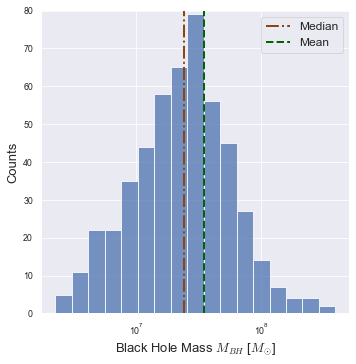

In [43]:
sns.displot(data=qsos, x='Wu_BH_mass', palette='colorblind', log_scale=True)
plt.vlines(qsos['Wu_BH_mass'].median(), 0, 80, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['Wu_BH_mass'].mean(), 0, 80, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 80)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'Black Hole Mass $M_{BH}$ [$M_{\odot}$]', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('Plots/Wu_BH_mass_distr.pdf')

plt.show()

/Users/nicolasgalvarinoguerravaras/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


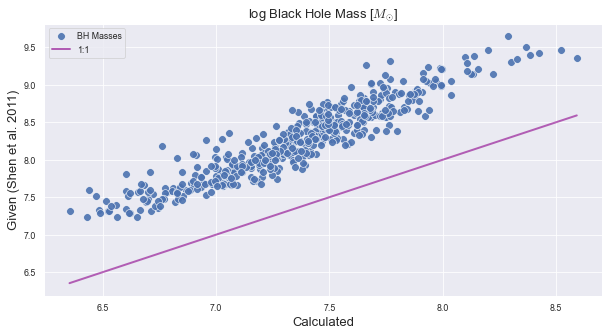

In [44]:
f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='log_Wu_BH_mass', y='log_BH_mass', palette='colorblind', 
                s=60, alpha=0.9, label='BH Masses')

x_to_plot = np.linspace(qsos['log_Wu_BH_mass'].min(), qsos['log_Wu_BH_mass'].max(), 50)
sns.lineplot(x_to_plot, x_to_plot, linewidth=2, color='darkmagenta', label='1:1', alpha=0.6)

plt.xlabel(r'Calculated', fontsize=13);
plt.ylabel('Given (Shen et al. 2011)', fontsize=13);
plt.title(r'log Black Hole Mass [$M_{\odot}$]', fontsize=13);

# plt.savefig('Plots/calculated_vs_given_Wu_BH_Mass.pdf')

plt.show()

I note that once again my calculated values are systematically lower than the given ones. It is because my estimates of the luminosity are lower than the given values (see previous plot). However, the estimated values range from $10^{6.35} M_{\odot}$ up to $10^{8.59} M_{\odot}$, which are well within the expected masses of a supermassive BH (SMBH): $10^{6} M_{\odot}$ up to $10^{10} M_{\odot}$. Thus, this estimate is sound.

### Bolometric Luminosity

I'll estimate the bolometric luminosity using equation 8 of the paper:
\begin{align}
    \log{L_{bol}} = \left ( 0.94 \pm 0.03 \right) \log{L_{ \text{H}\beta }} + (5.39 \pm 1.14)
\end{align}

This equation assumes that:
* $ L_{bol} = 9 L_{5100} $, where $L_{5100}$ is the monochromatic luminosity at $5100$ Ang.
* the galaxies are radio quiet, and thus, their optical thermal emission is not contaminated by non-thermal synchrotron emission.

It is specially useful for sources whose emission is likely contaminated by the beam of relativistic jets.

In [45]:
def log_Lbol_Wu(log_L_h_beta):
    '''
    Formula #8 from Wu 2009

    Input:
    log_L_h_beta: log of the luminosity of H beta line in erg / s

    Output:
    log of the bolometric luminosity in erg / s
    '''
    return 0.94 * log_L_h_beta + 5.39

In [46]:
qsos['Wu_log_Lbol'] = qsos.apply(lambda x: log_Lbol_Wu(x['my_log_L_h_beta']), axis=1)
qsos['Wu_Lbol'] = qsos.apply(lambda x: 10**(x['Wu_log_Lbol']), axis=1)
qsos[['Wu_Lbol', 'Wu_log_Lbol', 'log_Lbol']].describe()

,Wu_Lbol,Wu_log_Lbol,log_Lbol
count,5.000000e+02,500.000000,500.000000
mean,4.475797e+44,44.484465,45.231022
std,4.808522e+44,0.378290,0.213591
min,2.091523e+43,43.320463,44.818000
25%,1.729378e+44,44.237887,45.088000
50%,3.078809e+44,44.488373,45.189500
75%,5.522894e+44,44.742165,45.330500
max,4.431279e+45,45.646529,46.118000


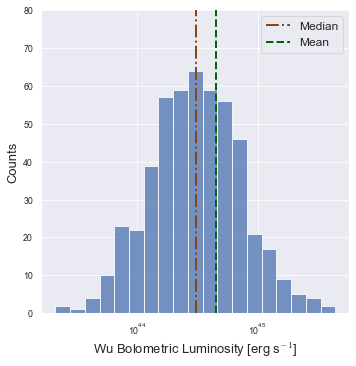

In [47]:
sns.displot(data=qsos, x='Wu_Lbol', palette='colorblind', log_scale=True)
plt.vlines(qsos['Wu_Lbol'].median(), 0, 80, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['Wu_Lbol'].mean(), 0, 80, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 80)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'Wu Bolometric Luminosity [erg s$^{-1}$]', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('Plots/Wu_Lbol_distr.pdf')

plt.show()

/Users/nicolasgalvarinoguerravaras/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


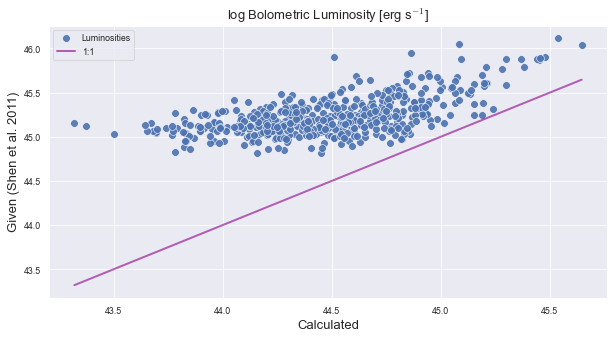

In [48]:
f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='Wu_log_Lbol', y='log_Lbol', palette='colorblind', 
                s=60, alpha=0.9, label='Luminosities')

x_to_plot = np.linspace(qsos['Wu_log_Lbol'].min(), qsos['Wu_log_Lbol'].max(), 50)
sns.lineplot(x_to_plot, x_to_plot, linewidth=2, color='darkmagenta', label='1:1', alpha=0.6)

plt.xlabel(r'Calculated', fontsize=13);
plt.ylabel('Given (Shen et al. 2011)', fontsize=13);
plt.title(r'log Bolometric Luminosity [erg s$^{-1}$]', fontsize=13);

# plt.savefig('Plots/calculated_vs_given_Wu_Lbol.pdf')

plt.show()

The estimates have reasonable values, as they are in the same order of magnitude as the given values. Wu et al. 2009 mentions that the values obtained from this empirical formula are expected to be to be 3 times larger than the ones used with this popular relation:
\begin{align}
    L_{bol} = 10 L_{BLR} = 252.6 L_{ \text{H}\beta }
\end{align}

(maybe check later)

### Eddington Luminosity \& Ratio

Now, I'll estimate the Eddington luminosity $L_{Edd}$ and ratio $L_{bol} / L_{Edd}$. For this, I'll use this relation, which appears in Section 4.1 of the paper by Wu:
\begin{align}
    L_{Edd} = 1.38 \times 10^{38} \frac{M_{BH}}{M_{\odot}} [\text{erg s}^{-1}]
\end{align}

In [49]:
def L_Edd(M_BH):
    '''
    Input:
    M_BH: black hole mass in solas masses

    Output:
    Eddington luminosity in erg / s
    '''
    return 1.38e38 * M_BH

In [50]:
qsos['L_Edd'] = qsos.apply(lambda x: L_Edd(x['Wu_BH_mass']), axis=1)
qsos['log_L_Edd'] = np.log10(qsos['L_Edd'])
qsos[['L_Edd', 'log_L_Edd']].describe()

,L_Edd,log_L_Edd
count,5.000000e+02,500.000000
mean,4.759948e+45,45.500514
std,5.470626e+45,0.391132
min,3.113555e+44,44.493257
25%,1.657477e+45,45.219447
50%,3.324305e+45,45.521701
75%,5.874384e+45,45.768960
max,5.383894e+46,46.731096


In [51]:
qsos['Shen_L_Edd'] = qsos.apply(lambda x: L_Edd(10**(x['log_BH_mass'])), axis=1)
qsos['log_Shen_L_Edd'] = np.log10(qsos['Shen_L_Edd'])
qsos[['Shen_L_Edd', 'log_Shen_L_Edd']].describe()

,Shen_L_Edd,log_Shen_L_Edd
count,5.000000e+02,500.000000
mean,4.894951e+46,46.404399
std,6.898243e+46,0.499644
min,2.343576e+45,45.369879
25%,1.071221e+46,46.029879
50%,2.540434e+46,46.404879
75%,5.886797e+46,46.769879
max,6.164234e+47,47.789879


In [52]:
def Edd_ratio(L_Edd, L_bol):
    '''
    Input:
    L_Edd: Eddington luminosity in erg / 
    L_bol: Bolometric luminosity in erg / 

    Output:
    Eddington ratio [dimensionless]
    '''
    return L_bol / L_Edd

In [53]:
qsos['Edd_ratio'] = qsos.apply(lambda x: Edd_ratio(x['L_Edd'], x['Wu_Lbol']), axis=1)
qsos['log_Edd_ratio'] = np.log10(qsos['Edd_ratio'])
qsos[['Edd_ratio', 'log_Edd_ratio']].describe()

,Edd_ratio,log_Edd_ratio
count,500.000000,500.000000
mean,0.214544,-1.016049
std,0.272146,0.598673
min,0.002263,-2.645226
25%,0.033685,-1.472562
50%,0.101335,-0.994259
75%,0.291652,-0.535176
max,1.568810,0.195570


In [55]:
qsos['Shen_Edd_ratio'] = qsos.apply(lambda x: Edd_ratio(x['Shen_L_Edd'], 10**(x['log_Lbol'])), axis=1)
qsos['log_Shen_Edd_ratio'] = np.log10(qsos['Shen_Edd_ratio'])
qsos[['Shen_Edd_ratio', 'log_Shen_Edd_ratio']].describe()

,Shen_Edd_ratio,log_Shen_Edd_ratio
count,500.000000,500.000000
mean,0.127465,-1.173377
std,0.153735,0.519528
min,0.003014,-2.520879
25%,0.026295,-1.580129
50%,0.068568,-1.163879
75%,0.172136,-0.764129
max,1.064439,0.027121


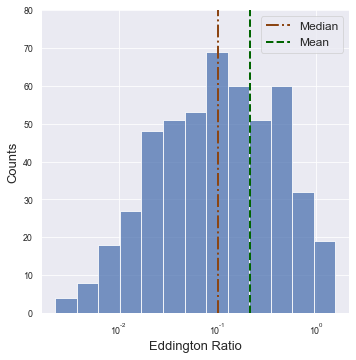

In [56]:
sns.displot(data=qsos, x='Edd_ratio', palette='colorblind', log_scale=True)
plt.vlines(qsos['Edd_ratio'].median(), 0, 80, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['Edd_ratio'].mean(), 0, 80, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 80)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'Eddington Ratio', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('Plots/Edd_ratio_distr.pdf')

plt.show()

These values for the Eddington ratio are within the expected range, but lower than the values found by Wu 2009, which had a mean of about 0.56 in log scale. There are ~20 QSOs with a super-Eddington luminosity (Eddington Ratio > 1).

### About the Sample

To get a physically relevant description of the QSOs, I'll get some useful plots to compare the values obtained by using the relations in Wu 2009 and the ones given by Shen et al. 2011, apart from the already obtained histograms:

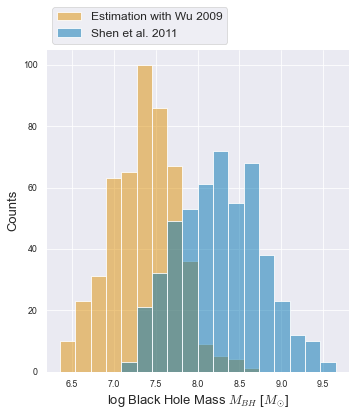

In [57]:
sns.displot(data=qsos[['log_BH_mass', 'log_Wu_BH_mass']], palette='colorblind', 
            log_scale=False, legend=False)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'log Black Hole Mass $M_{BH}$ [$M_{\odot}$]', fontsize=13);
plt.legend(['Estimation with Wu 2009', 'Shen et al. 2011'], loc='lower left', bbox_to_anchor=(0, 1), fontsize=12)

# plt.savefig('Plots/BH_mass_Shen_vs_Wu.pdf', bbox_inches='tight')

plt.show()

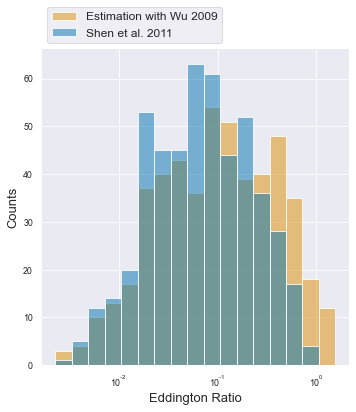

In [58]:
sns.displot(data=qsos[['Shen_Edd_ratio', 'Edd_ratio']], palette='colorblind', 
            log_scale=True, legend=False)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'Eddington Ratio', fontsize=13);
plt.legend(['Estimation with Wu 2009', 'Shen et al. 2011'], loc='lower left', bbox_to_anchor=(0, 1), fontsize=12)

# plt.savefig('Plots/final_Edd_ratio_distr.pdf', bbox_inches='tight')

plt.show()

A relevant difference here is that Shen et al. 2011 didn't obtain any super-Eddington sources.

#### $L_{ \text{H}\beta }$ vs $L_{bol}$

In [86]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(qsos['my_log_L_h_beta'].to_numpy().reshape(-1, 1), 
                                                        qsos['Wu_log_Lbol'].to_numpy().reshape(-1, 1), 
                                                        train_size=0.7, random_state=42)

ols_ = linear_model.LinearRegression()
linear_ = ols_.fit(x_train_, y_train_)  # fits the training data
y_pred_ = linear.predict(x_test_)

# testing with the test set
print('Test MSE = ', mean_squared_error(y_test_, y_pred_))
print('Train MSE = ', mean_squared_error(y_train_, linear_.predict(x_train_)))

print('R2 Score: %.2f' % r2_score(y_test_, y_pred_))
print(' ')
print('Correlation Coefficients: \n', ols_.coef_)

Test MSE =  3.500438790100703e-29
Train MSE =  3.375423119025678e-29
R2 Score: 1.00
 
Correlation Coefficients: 
 [[0.94]]


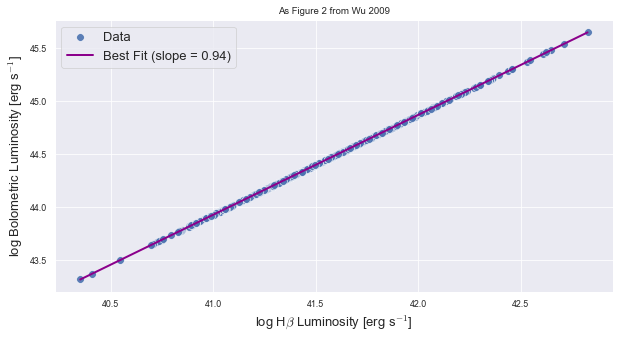

In [93]:
# Fig 2 from Wu 2009
# loglog: luminosities: H beta vs bol

f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='my_log_L_h_beta', y='Wu_log_Lbol', palette='colorblind', 
                s=60, alpha=0.9, label='Data')

x_to_plot = np.linspace(qsos['my_log_L_h_beta'].min(), qsos['my_log_L_h_beta'].max(), 50).reshape(-1, 1)
ax.plot(x_to_plot, linear_.predict(x_to_plot), '-', color='darkmagenta', linewidth=2, label='Best Fit (slope = 0.94)')

plt.xlabel(r'log H$\beta$ Luminosity [erg s$^{-1}$]', fontsize=13);
plt.ylabel(r'log Bolometric Luminosity [erg s$^{-1}$]', fontsize=13);
plt.title('As Figure 2 from Wu 2009')

plt.legend(fontsize=13);

# plt.savefig('Plots/L_Hb_vs_Lbol.pdf')

plt.show()

This is my version of Figure 2 from Wu 2009. This correlation between the H $\beta$ and bolometric luminositires has remarkably low dispersion. In the paper, they plot this graph for a sample of radio quiet AGN from Kaspi et al. 2005. Thus, this sample might be radio quiet as well. However, they don't present a similar graph for radio loud AGN, so it is not possible to know it they would follow the same trend or not.

#### Eddington Ratio vs BH Mass

In [87]:
x_train, x_test, y_train, y_test = train_test_split(qsos['log_Edd_ratio'].to_numpy().reshape(-1, 1), 
                                                    qsos['log_Wu_BH_mass'].to_numpy().reshape(-1, 1), 
                                                    train_size=0.7, random_state=42)

ols = linear_model.LinearRegression()
linear = ols.fit(x_train, y_train)  # fits the training data
y_pred = linear.predict(x_test)

# testing with the test set
print('Test MSE = ', mean_squared_error(y_test, y_pred))
print('Train MSE = ', mean_squared_error(y_train, linear.predict(x_train)))

print('R2 Score: %.2f' % r2_score(y_test, y_pred))
print(' ')
print('Correlation Coefficients: \n', ols.coef_)

Test MSE =  0.0586753522658871
Train MSE =  0.058204865483650475
R2 Score: 0.62
 
Correlation Coefficients: 
 [[-0.52421338]]


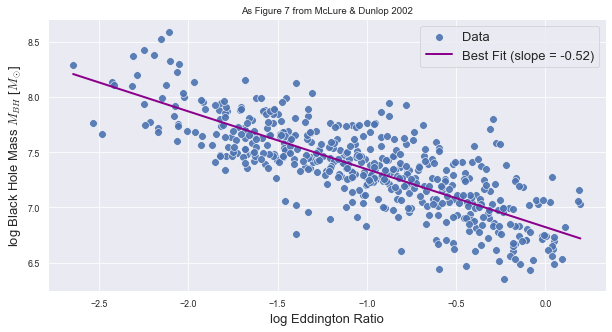

In [92]:
# Fig 7 from McLure & Dunlop 2002
# loglog: Edd ratio vs BH mass
# best linear fit
# Eddington limit

f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='log_Edd_ratio', y='log_Wu_BH_mass', palette='colorblind', 
                s=60, alpha=0.9, label='Data')

x_to_plot = np.linspace(qsos['log_Edd_ratio'].min(), qsos['log_Edd_ratio'].max(), 50).reshape(-1, 1)
ax.plot(x_to_plot, linear.predict(x_to_plot), '-', color='darkmagenta', linewidth=2, label='Best Fit (slope = -0.52)')

plt.xlabel('log Eddington Ratio', fontsize=13);
plt.ylabel(r'log Black Hole Mass $M_{BH}$ [$M_{\odot}$]', fontsize=13);
plt.title('As Figure 7 from McLure & Dunlop 2002')

plt.legend(fontsize=13);

# plt.savefig('Plots/Edd_ratio_vs_BH_mass.pdf')

plt.show()

This is my version of Figure 7 from McLure & Dunlop 2002. The biggest difference is that in their paper, the slope is positive, but mine is negative. However, in the paper, different types of AGN behave differently: Seyfert galaxies are the ones that have the steepest slope, whilst QSOs have a less steep slope (circles in the paper). The galaxies here behave much more like QSOs than Seyfert galaxies, which is already known. Furthermore, it is difficult based on this graph to properly differentiate between radio loud and radio quiet.

---

Based on both of these graphs, it is sensible to say that this sample may be mostly composed of radio quiet, since they follow the behaviour of the radio quiet AGN from Wu 2009. However, it is not possible to discard the possibility that they may be radio loud.

## Bulge Luminosity of the Host Galaxy

Now, I'll calculate the the BH mass of the sources in Wu 2009 using the following relation:
\begin{align}
    \log{\frac{M_{BH}}{M_{\odot}}} = -0.5 M_R - 2.74,
\end{align}

where $M_R$ is the absolute magnitude of the host galaxy in the R band. This relation was proposed by McLure & Dunlop 2002, and is valid for both AGN and inactive galaxies.

But I need the absolute magnitudes. To get them, I will:
1. Get the Wu 2009 sample to have their general information like coordinates and redshift.
2. Find the apparent magnitudes in SIMBAD. The problem is that both tables use different identifier names. So I'll cross-match with coordinates.
3. SIMBAD has coordinates in hours:minutes:seconds. So I'll convert them to degrees.
4. Cross-match the tables, and asign each object in the table obtained on SIMBAD with its redshift.
5. Find the luminosity distance the same way as before.
6. Convert the apparent magnitude to the absolute one with:
\begin{align}
    M = m - 5 \log{d_{pc}} + 5
\end{align}

This might be a bit overly complicated. However, I find it better than looking up each object one by one.

Then, I'll get the bolometric luminosities with an expression found in Wu 2009:
\begin{align}
    L_{bol} \approx 10 \times L_{opt}
\end{align}
where $L_{opt}$ is the optical luminosity. I'll use the luminosity in the R band for this, and I'll go from absolute magnitude to luminosity with:
\begin{align}
    L_R = L_0 \times 10^{-0.4 M_R}
\end{align}
where $L_0 = 3.0128 \times 10^{28}$ W = $3.0128 \times 10^{35}$ erg s$^{-1}$.

---

First, I looked for the Wu 2009 sample in the NED database:

In [96]:
Wu_sample = pd.read_csv('Wu_2009_sample.csv', sep=',')
Wu_sample.drop('No.', axis=1, inplace=True)
Wu_sample

,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations,Redshift-independent Distances,Classifications,Images,Spectra
0,CGCG 186-048,176.842210,35.018756,G,1.887433e+04,0.062958,SLS,163,6.0,79,33,21,6.0,NaN,1.0,8.0,9.0,NaN
1,UGC 08782,208.074342,31.446250,G,1.354888e+04,0.045194,SPEC,383,12.0,191,48,32,14.0,3.0,NaN,8.0,16.0,5.0
2,3C 043,22.499205,23.638966,QSO,4.373972e+05,1.459000,SPEC,194,7.0,122,19,8,NaN,NaN,NaN,5.0,6.0,NaN
3,3C 048,24.422081,33.159759,QSO,1.106234e+05,0.369000,SLS,799,18.0,259,44,16,4.0,NaN,NaN,6.0,16.0,1.0
4,[HB89] 0237-233,40.034060,-23.154369,QSO,6.664386e+05,2.223000,SLS,440,8.0,110,41,19,NaN,NaN,NaN,4.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,WISEA J195930.12+620644.8,299.875500,62.112417,QSO,5.468214e+05,1.824000,NaN,18,1.0,18,4,1,NaN,1.0,NaN,1.0,NaN,NaN
61,WISEA J235509.45+495008.3,358.789411,49.835650,G,7.132063e+04,0.237900,NaN,191,3.0,62,15,5,NaN,NaN,NaN,5.0,11.0,1.0
62,WISEA J013416.90-425826.2,23.570417,-42.974167,G,7.109098e+04,0.237134,SLS,39,2.0,34,8,4,NaN,NaN,NaN,1.0,1.0,1.0
63,WISEA J153929.53+591100.6,234.872958,59.183528,QSO,1.162595e+06,3.878000,NaN,15,NaN,18,3,1,NaN,NaN,NaN,2.0,NaN,NaN


Then I looked for them on SIMBAD and got the ones that have values for apparent magnitude in the R band.

In [194]:
simbad_Wu_sample = pd.read_csv('simbad_Wu_2009.csv', delimiter=',')
simbad_Wu_sample.drop('N', axis=1, inplace=True)
simbad_Wu_sample

,Identifier,Otype,RA,DEC,Mag B,Mag V,Mag R
0,7C 1144+3517,BLL,11 47 22.1297825184,+35 01 07.538786184,17.890,16.83,10.260
1,7C 155054.79+581551.00,QSO,15 51 58.2078070152,+58 06 44.454684204,17.030,16.73,15.600
2,ICRF J134733.3+121724,Sy2,13 47 33.36161873,+12 17 24.2398927,19.280,18.44,15.718
3,2MASX J20210438-2235183,Sy1,20 21 04.0639,-22 35 25.775,17.530,16.80,16.280
4,2MASS J01341690-4258262,Sy1,01 34 16.9072341600,-42 58 26.223391344,18.170,17.30,16.710
5,ICRF J182931.7+484446,Sy1,18 29 31.7809732968,+48 44 46.160168892,17.050,16.81,16.860
6,QSO B2134+0028,QSO,21 36 38.58632232,+00 41 54.2128562,17.300,17.08,17.020
7,QSO B1946+708,BLL,19 45 53.51966298,+70 55 48.7285673,18.726,16.70,17.199
8,3C 186,QSO,07 44 17.4720658920,+37 53 17.250697320,17.500,18.14,17.200
9,ICRF J145907.5+714019,Sy1,14 59 07.58390804,+71 40 19.8668093,17.240,16.78,17.200


In [195]:
# re-writing RA and DEC so that astropy can process them
def hms_str_formatting(coor, ra_or_dec):
    '''
    Input:
    coor: coordinate
    ra_or_dec: 'ra' or 'dec'. astropy needs to know

    Output:
    coor ready for astropy
    '''
    if ra_or_dec == 'ra':
        h = coor[0:2]
        m = coor[3:5]
        s = coor[6:]
        string = h + 'h' + m + 'm' + s + 's'
    elif ra_or_dec == 'dec':
        sign = coor[0]
        d = coor[1:3]
        m = coor[4:6]
        s = coor[7:]
        string = sign + d + 'd' + m + 'm' + s + 's'
    return string

In [196]:
simbad_Wu_sample['RA_astropy'] = simbad_Wu_sample.apply(lambda x: hms_str_formatting(x['RA'], 'ra'), axis=1)
simbad_Wu_sample['DEC_astropy'] = simbad_Wu_sample.apply(lambda x: hms_str_formatting(x['DEC'], 'dec'), axis=1)
simbad_Wu_sample[['RA', 'DEC', 'RA_astropy', 'DEC_astropy']]

,RA,DEC,RA_astropy,DEC_astropy
0,11 47 22.1297825184,+35 01 07.538786184,11h47m22.1297825184s,+35d01m07.538786184s
1,15 51 58.2078070152,+58 06 44.454684204,15h51m58.2078070152s,+58d06m44.454684204s
2,13 47 33.36161873,+12 17 24.2398927,13h47m33.36161873s,+12d17m24.2398927s
3,20 21 04.0639,-22 35 25.775,20h21m04.0639s,-22d35m25.775s
4,01 34 16.9072341600,-42 58 26.223391344,01h34m16.9072341600s,-42d58m26.223391344s
5,18 29 31.7809732968,+48 44 46.160168892,18h29m31.7809732968s,+48d44m46.160168892s
6,21 36 38.58632232,+00 41 54.2128562,21h36m38.58632232s,+00d41m54.2128562s
7,19 45 53.51966298,+70 55 48.7285673,19h45m53.51966298s,+70d55m48.7285673s
8,07 44 17.4720658920,+37 53 17.250697320,07h44m17.4720658920s,+37d53m17.250697320s
9,14 59 07.58390804,+71 40 19.8668093,14h59m07.58390804s,+71d40m19.8668093s


In [197]:
def hms_to_deg(row):
    ra_hms = row['RA_astropy']
    dec_dms = row['DEC_astropy']
    
    c = SkyCoord(ra_hms, dec_dms, frame='icrs')

    return c

In [198]:
simbad_Wu_sample['RA_deg'] = simbad_Wu_sample.apply(lambda x: hms_to_deg(x).ra.deg, axis=1)
simbad_Wu_sample['DEC_deg'] = simbad_Wu_sample.apply(lambda x: hms_to_deg(x).dec.deg, axis=1)
simbad_Wu_sample[['RA_deg', 'DEC_deg']]

,RA_deg,DEC_deg
0,176.842207,35.018761
1,237.992533,58.112349
2,206.889007,12.290067
3,305.266933,-22.590493
4,23.570447,-42.973951
5,277.382421,48.746156
6,324.160776,0.698392
7,296.472999,70.930202
8,116.072800,37.888125
9,224.781600,71.672185


Now, we cross-match. It results in only 17 objects, but this is still enough.

In [209]:
simbad_Wu_sample['redshift'] = Wu_sample.loc[Wu_sample['RA'] - simbad_Wu_sample['RA_deg'] < 0.0001]['Redshift']
simbad_Wu_sample['redshift'].describe()

count    17.000000
mean      0.971304
std       0.945795
min       0.045194
25%       0.305981
50%       0.692000
75%       1.436208
max       3.540681
Name: redshift, dtype: float64

Now, we finally get the absolute magnitudes.

In [203]:
simbad_Wu_sample['D_L'] = simbad_Wu_sample.apply(lambda x: np.float64(cosmo.luminosity_distance(np.float64(x['redshift']))) * 1e6, axis=1)
simbad_Wu_sample['D_L']

0     2.915252e+08
1     2.066521e+08
2     1.080369e+10
3     2.034141e+09
4              NaN
5     1.969474e+10
6     4.832565e+09
7     3.232231e+09
8     7.333107e+09
9     1.559720e+10
10             NaN
11    1.345979e+09
12    1.723712e+09
13    7.244062e+09
14             NaN
15    1.059628e+10
16    3.168330e+10
17             NaN
18             NaN
19             NaN
20    4.316739e+09
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27    1.277430e+09
28    1.636379e+09
Name: D_L, dtype: float64

In [204]:
def abs_mag(apa_mag, distance):
    return apa_mag - 5 * np.log10(distance) + 5

In [210]:
simbad_Wu_sample['Abs Mag R'] = simbad_Wu_sample.apply(lambda x: abs_mag(x['Mag R'], x['D_L']), axis=1)
simbad_Wu_sample['Abs Mag R'].describe()

count    16.000000
mean    -25.789351
std       3.075861
min     -29.611751
25%     -27.655633
50%     -26.700400
75%     -23.810790
max     -20.621686
Name: Abs Mag R, dtype: float64

These values are reasonable for QSOs. Now we can calculate the BH mass.

In [119]:
def M_BH_Rmag(M_R, log=True):
    '''
    Formula #7 from Wu 2000

    Inputs:
    M_R: R band absolute magnitude

    Output:
    BH mass in solar masses
    If log is set to True (default), output is log of the BH mass
    If log is set to False, output is simple BH mass, not log
    '''
    BH_mass = - 0.5 * M_R - 2.74
    if log:
        return BH_mass
    else:
        return 10**BH_mass

In [207]:
simbad_Wu_sample['M_BH_Rmag'] = simbad_Wu_sample.apply(lambda x: M_BH_Rmag(x['Abs Mag R'], log=False), axis=1)
simbad_Wu_sample['log_M_BH_Rmag'] = simbad_Wu_sample.apply(lambda x: M_BH_Rmag(x['Abs Mag R']), axis=1)
simbad_Wu_sample[['M_BH_Rmag', 'log_M_BH_Rmag']].describe()

,M_BH_Rmag,log_M_BH_Rmag
count,1.600000e+01,16.000000
mean,2.444388e+11,10.154676
std,4.163607e+11,1.537931
min,3.722573e+07,7.570843
25%,1.507403e+09,9.165395
50%,4.320396e+10,10.610200
75%,1.697599e+11,11.087817
max,1.163793e+12,12.065876


These values are quite high. It is unusual to find AGN with a SMBH more massive than $10^{10} M_{\odot}$. Maybe this is due to all the improvised methods?

The Eddington luminosities are here:

In [208]:
simbad_Wu_sample['L_Edd'] = simbad_Wu_sample.apply(lambda x: L_Edd(x['M_BH_Rmag']), axis=1)
simbad_Wu_sample['log_L_Edd'] = np.log10(simbad_Wu_sample['L_Edd'])
simbad_Wu_sample[['L_Edd', 'log_L_Edd']].describe()

,L_Edd,log_L_Edd
count,1.600000e+01,16.000000
mean,3.373255e+49,48.294555
std,5.745778e+49,1.537931
min,5.137150e+45,45.710722
25%,2.080216e+47,47.305274
50%,5.962146e+48,48.750079
75%,2.342686e+49,49.227696
max,1.606034e+50,50.205755


Now, we can get the bolometric luminosities from the R band.

\begin{align}
L_{bol} \approx 10 \times L_{opt}
\end{align}

\begin{align}
    L_R = L_0 \times 10^{-0.4 M_R}
\end{align}

In [211]:
simbad_Wu_sample.columns

Index(['Identifier', 'Otype', 'RA', 'DEC', 'Mag B', 'Mag V', 'Mag R',
       'RA_astropy', 'DEC_astropy', 'RA_deg', 'DEC_deg', 'redshift', 'D_L',
       'Abs Mag R', 'M_BH_Rmag', 'log_M_BH_Rmag', 'L_Edd', 'log_L_Edd'],
      dtype='object')

In [212]:
L0 = 3.0128e35
simbad_Wu_sample['L_R'] = simbad_Wu_sample.apply(lambda x: L0 * 10**(-0.4 * x['Abs Mag R']), axis=1)
simbad_Wu_sample['L_bol'] = simbad_Wu_sample.apply(lambda x: 10 * x['L_R'], axis=1)
simbad_Wu_sample[['L_Edd', 'L_R', 'L_bol']].describe()

,L_Edd,L_R,L_bol
count,1.600000e+01,1.600000e+01,1.600000e+01
mean,3.373255e+49,4.911757e+46,4.911757e+47
std,5.745778e+49,7.593014e+46,7.593014e+47
min,5.137150e+45,5.341274e+43,5.341274e+44
25%,2.080216e+47,1.027268e+45,1.027268e+46
50%,5.962146e+48,1.497785e+46,1.497785e+47
75%,2.342686e+49,4.270456e+46,4.270456e+47
max,1.606034e+50,2.107030e+47,2.107030e+48


We finally have the Eddington ratios:

In [213]:
simbad_Wu_sample['Edd_ratio'] = simbad_Wu_sample.apply(lambda x: Edd_ratio(x['L_Edd'], x['L_bol']), axis=1)
simbad_Wu_sample['log_Edd_ratio'] = np.log10(simbad_Wu_sample['Edd_ratio'])
simbad_Wu_sample[['Edd_ratio', 'log_Edd_ratio']].describe()

,Edd_ratio,log_Edd_ratio
count,16.000000,16.000000
mean,0.040559,-1.499844
std,0.031566,0.307586
min,0.013119,-1.882084
25%,0.020796,-1.686472
50%,0.025709,-1.590949
75%,0.049957,-1.301988
max,0.103973,-0.983077
